# MAFAT 2025 Semantic Retrieval Competition - Exploratory Data Analysis

This notebook performs exploratory data analysis on the Israeli semantic retrieval competition dataset.

## Import Libraries and Setup

First, we'll import all necessary libraries for data analysis and visualization.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import warnings
warnings.filterwarnings('ignore')


## Download training data

## Data Loading

Load the JSONL dataset containing query-paragraph pairs with relevance scores for the semantic retrieval competition.


In [3]:
import json

file_path = './hsrc/hsrc_train.jsonl'
rows = []
with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
        rows.append(json.loads(line))

df = pd.DataFrame(rows)


Select the data for analysis and display.
(note that running the notebook on the full dataset will not be possible in a standard collab)

## EDA

### Overview

The competition's data consists of the following columns:
1. query_uuid - unique identifier for query
2. query - query text
3. paragraphs - list of paragraphs with uuid and passage for each one
4. target_actions - list of target actions for each paragraph and query
5. case_name - data corpuses - source


## Initial Data Exploration

Let's first examine the structure of our dataset by looking at the column names and basic information.


In [4]:
df.columns

Index(['query_uuid', 'query', 'paragraphs', 'target_actions', 'case_name'], dtype='object')

### Dataset Preview

Display the first few rows to understand the data structure and content.


In [5]:
data_head = df.head()
display(data_head)

,query_uuid,query,paragraphs,target_actions,case_name
0,5c947053-f115-4ddd-86ab-a4706e75bd67,מה התשלום עבור דרגה X במעון או משפחתון?\n מה ה...,{'paragraph_0': {'uuid': '2a159d69-8d41-4de1-a...,"{'target_action_0': '2', 'target_action_1': '1...",mafat_retrieval_kz_corpus
1,569e2b5a-d1c5-4aca-a0aa-b8d6b6b2093f,"מי ביים את הסרט ""שתיקת הכבשים""?",{'paragraph_0': {'uuid': '31f1fbb7-bab9-4a2b-a...,"{'target_action_0': '4', 'target_action_1': '2...",mafat_retrieval_wikipedia_corpus
2,d5c1de3e-93a7-40e4-8d23-4a1fc4a39cf0,"מי יו""ר ועדת חוץ וביטחון בכנסת?",{'paragraph_0': {'uuid': '8e61604d-4eb4-4c68-a...,"{'target_action_0': '0', 'target_action_1': '4...",mafat_retrieval_knesset_corpus
3,d0c08ef6-2671-430c-86de-6b467e6127ae,מה צבע הכומתה של תותחנים?,{'paragraph_0': {'uuid': '57488608-a8da-4949-a...,"{'target_action_0': '0', 'target_action_1': '0...",mafat_retrieval_wikipedia_corpus
4,d13c6cef-f315-4748-bb81-9798e52a0ca2,למה הממשלה מוסמכת לחוקק חוקי-יסוד עם תחולה מיי...,{'paragraph_0': {'uuid': '1b8a6610-e485-41f5-8...,"{'target_action_0': '0', 'target_action_1': '0...",mafat_retrieval_knesset_corpus


### Dataset Composition

Examine the different case names (corpuses) present in the dataset to understand the variety of content.


In [6]:
# Display the unique corpuses in the dataset
unique_corpuses = df['case_name'].unique()
print("Unique corpuses:", unique_corpuses)

Unique corpuses: ['mafat_retrieval_kz_corpus' 'mafat_retrieval_wikipedia_corpus'
 'mafat_retrieval_knesset_corpus']


## Data Preprocessing

Create a working copy of the dataset for transformation and analysis.


In [7]:
df = df.copy()

### Data Structure Transformation

The dataset contains nested dictionaries for paragraphs and target actions. We need to unwrap these structures to make the data more accessible for analysis.

These functions will:
- Extract paragraph UUIDs and text content from the nested paragraph structure
- Extract relevance scores from the target actions structure
- Maintain proper ordering based on paragraph indices


In [8]:
import pandas as pd

def unwrap_paragraphs(par_dict):
    # sort items by the numeric suffix of "paragraph_i"
    items = sorted(
        par_dict.items(),
        key=lambda kv: int(kv[0].split('_')[-1])
    )
    uuids   = [v['uuid']    for _, v in items]
    texts   = [v['passage'] for _, v in items]
    return uuids, texts

def unwrap_targets(tgt_dict):
    # sort items by the numeric suffix of "target_action_i"
    items = sorted(
        tgt_dict.items(),
        key=lambda kv: int(kv[0].split('_')[-1])
    )
    rels = [v for _, v in items]
    return rels

# apply to each row
df['paragraph_uuids'], df['paragraph_texts'] = \
    zip(*df['paragraphs'].map(unwrap_paragraphs))

df['relevances'] = df['target_actions'].map(unwrap_targets)

df.rename(columns={'case_name': 'source'}, inplace=True)

# sanity checks
assert all(len(x)==20 for x in df['paragraph_uuids'])
assert all(len(x)==20 for x in df['relevances'])

### Data Reshaping - Creating Long Format

Transform the data from wide format (one row per query with 20 paragraphs) to long format (one row per query-paragraph pair). This makes it easier to analyze relationships between queries, paragraphs, and relevance scores.


In [9]:
from IPython.display import display, HTML

# 0..19 positions
df['position'] = df['paragraph_uuids'].map(lambda lst: list(range(len(lst))))

# explode all in lock‐step
df_long = (
    df
    .explode(['paragraph_uuids','paragraph_texts','relevances','position'])
    .rename(columns={
        'paragraph_uuids':'paragraph_uuid',
        'paragraph_texts':'paragraph_text',
        'relevances':'relevance'
    })
    .reset_index(drop=True)
)

# keep only the columns you need
df_long = df_long[[
    'query_uuid','query','source',
    'position','paragraph_uuid','paragraph_text','relevance'
]]

print(df_long.shape)   # should be n_queries * 20 rows

(40680, 7)


### Sample Data by Source

Display one example from each source to understand the content and structure differences across different corpuses.


In [10]:
# Display 1 example per source
examples_per_source = df_long.groupby('source').apply(lambda group: group.head(1))
# Display the examples
display(HTML(examples_per_source.drop(columns=['source']).style.set_table_attributes('dir="rtl"').to_html(index=False, escape=False)))

,,query_uuid,query,position,paragraph_uuid,paragraph_text,relevance
source,,,,,,,
mafat_retrieval_knesset_corpus,40,d5c1de3e-93a7-40e4-8d23-4a1fc4a39cf0,"מי יו""ר ועדת חוץ וביטחון בכנסת?",0,8e61604d-4eb4-4c68-a4cc-0c99c6bb2498,"ולדימיר בליאק (יש עתיד): גברתי יושבת הראש, אני רוצה לברך את חבר הכנסת בן גביר על נאומו המרגש, המוקדש שכולו לסכנה שבגזענות. תודה רבה. איתמר בן גביר (הציונות הדתית): תודה, תשננו, תשננו. יו""ר הוועדה המסדרת עידית סילמן: תודה רבה. אנחנו עוברים להצבעה על הרביזיה, מי בעד הרביזיה? איתמר בן גביר (הציונות הדתית): דיון מחדש, למה לקרוא לזה רביזיה? יש לזה שם בעברית. יו""ר הוועדה המסדרת עידית סילמן: רעיון יפה, איתמר בן גביר, תודה על התוספת המשמעותית הזאת. איתמר בן גביר (הציונות הדתית): דיון מחדש. יו""ר הוועדה המסדרת עידית סילמן: מי נגד? מי נמנע? הצבעה בעד – 6 נגד – 9 לא אושרה. יו""ר הוועדה המסדרת עידית סילמן: שישה בעד, נגד תשעה, הרביזיה - - ינון אזולאי (ש""ס): טיבי ביקש להגיד שהוא נמנע. יו""ר הוועדה המסדרת עידית סילמן: לא לא, זהו. סיימנו את הרביזיה. ינון אזולאי (ש""ס): הוא לא פה. יו""ר הוועדה המסדרת עידית סילמן: הוא ביקש להגיד שהוא לא פה? בסדר גמור. - - נדחתה. תודה רבה. נעלנו, תודה. אשריך, איתמר, איך אמרת? דיון מחדש. חבר הכנסת אלכס קושניר, שיהיה לך בהצלחה.",0
mafat_retrieval_kz_corpus,0,5c947053-f115-4ddd-86ab-a4706e75bd67,מה התשלום עבור דרגה X במעון או משפחתון? מה הזכאות עבור ילד נוסף במסגרת מעון או משפחתון?,0,2a159d69-8d41-4de1-ad2d-e128b9980a9d,"דרגות השתתפות במימון מעונות יום ומשפחתונים גובה שכר הלימוד סכומי השתתפות המדינה והסכומים אותם משלימים ההורים עבור כל אחת מהדרגות, מפורטים בטבלאות שכר לימוד. הטבלאות מחולקות לפי תעריפים לילדים ותעריפים לתינוקות: גובה שכר הלימוד בהתאם לדרגות השונות מפורטת בטבלאות שכר לימוד במסגרות ילדים באתר משרד העבודה. הדרגות המופיעות בטבלאות מותאמות לגובה ההכנסה לנפש במשפחה. ככל שדרגת הזכאות (בטווח 12-3) נמוכה יותר, כך גדלה השתתפות המדינה בתשלום. עבור רמות ההשתתפות המותאמות לגובה ההכנסות, יש להוסיף או להפחית דרגות, על-פי מספר מספר הילדים השוהים במעון או במשפחתון - למשפחה עם כמה ילדים השוהים במעון או במשפחתון, תוגדל רמת השתתפות המדינה עבור כל אחד מהילדים (תיקבע דרגה נמוכה יותר בין הדרגות 12-3). תינוקות הם מי שגילם היה עד 15 חודשים ב-1 בספטמבר של שנת הלימודים אליה נרשמו. ילדים הם מי שב-1 בספטמבר של שנת הלימודים אליה נרשמו, גילם היה בין 15 חודשים ויום ל-33 חודשים (או עד לגיל 46 חודשים, למי שיש להם אישור מהיחידה להתפתחות הילד כי הם מעוכבי התפתחות). השפעת מספר הילדים השוהים במעון/משפחתון על דרגת ההשתתפות דרגה בהתאם לרמת הכנסה : 3 מספר הילדים הזכאים במשפחה : 2 הדרגה הסופית המותאמת : 14 השפעת מספר הילדים השוהים במעון/משפחתון על דרגת ההשתתפות דרגה בהתאם לרמת הכנסה : 3 מספר הילדים הזכאים במשפחה : 3 ומעלה הדרגה הסופית המותאמת : 15 השפעת מספר הילדים השוהים במעון/משפחתון על דרגת ההשתתפות דרגה בהתאם לרמת הכנסה מספר הילדים הזכאים במשפחה הדרגה הסופית המותאמת 3 2 14 3 3 ומעלה 15",2
mafat_retrieval_wikipedia_corpus,20,569e2b5a-d1c5-4aca-a0aa-b8d6b6b2093f,"מי ביים את הסרט ""שתיקת הכבשים""?",0,31f1fbb7-bab9-4a2b-a136-ff37e27bd612,"שתיקת הכבשים (באנגלית: The Silence of the Lambs) הוא סרט קולנוע אמריקאי מסוגת מותחן פסיכולוגי משנת 1991, בבימויו של ג'ונתן דמי. התסריט, שנכתב על ידי טד טלי, מבוסס על רומן באותו השם מאת תומאס האריס. הסרט זכה להצלחה רבה ובין השאר זכה בפרס אוסקר לסרט הטוב ביותר ובפרסי אוסקר נוספים לדמי, לטלי ולשחקנים הראשיים, ג'ודי פוסטר ואנתוני הופקינס. הצלחת הסרט הובילה להפקת סרטים נוספים שהתבססו על ספריו של תומאס האריס: ""חניבעל"", שהוא סרט המשך, פריקוול בשם ""מקור הרוע"", וכן ""דרקון אדום"", בו ללקטר מקום משני שהובלט בסרט. ""שתיקת הכבשים"" הפך לביטוי שגור, הבא לבקר שתיקה של אדם או ציבור לנוכח מצב או תופעה שליליים, במקום להשמיע קול מחאה. למשל: ""נאום שתיקת הכבשים"".",4


## Dataset Statistics

Generate summary statistics to understand the scale and composition of our dataset.


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

print("Rows:",      len(df_long))
print("Queries:",   df_long['query_uuid'].nunique())
print("Paragraphs:", len(df_long))
print("Relevance labels:", sorted(df_long['relevance'].unique()))
df_long.info()

Rows: 40680
Queries: 2034
Paragraphs: 40680
Relevance labels: ['0', '1', '2', '3', '4']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40680 entries, 0 to 40679
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   query_uuid      40680 non-null  object
 1   query           40680 non-null  object
 2   source          40680 non-null  object
 3   position        40680 non-null  object
 4   paragraph_uuid  40680 non-null  object
 5   paragraph_text  40680 non-null  object
 6   relevance       40680 non-null  object
dtypes: object(7)
memory usage: 2.2+ MB


### Data Quality Check

Identify any problematic relevance labels that need to be cleaned or handled specially.


In [12]:
wrong_relevance_labels = df_long[df_long['relevance'].isin(['', '-', '9'])]
wrong_relevance_labels[['query_uuid','paragraph_uuid','relevance']]

,query_uuid,paragraph_uuid,relevance


### Data Cleaning

Clean the relevance scores by:
- Converting to numeric format
- Removing invalid entries
- Filtering to valid relevance range (0-4)


In [13]:
df_long['relevance_num'] = pd.to_numeric(df_long['relevance'],
                                         errors='coerce')
df_long = df_long.dropna(subset=['relevance_num'])
df_long = df_long[df_long['relevance_num'] <= 4]

## Relevance Distribution Analysis

### Overall Relevance Distribution

Visualize the distribution of relevance scores across all query-paragraph pairs to understand label balance.


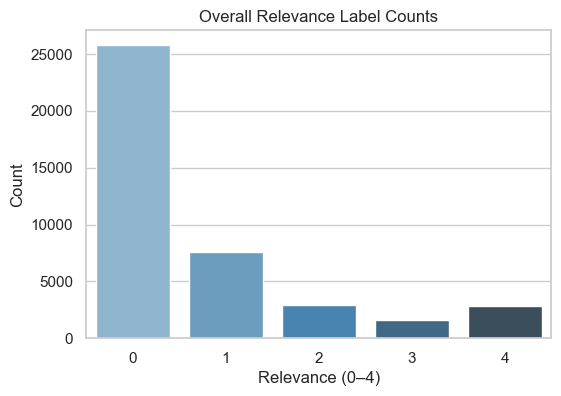

In [14]:
order = sorted(df_long['relevance_num'].unique(), key=int)
plt.figure(figsize=(6,4))
sns.countplot(x='relevance_num',
              data=df_long,
              order=order,
              palette="Blues_d")
plt.title("Overall Relevance Label Counts")
plt.xlabel("Relevance (0–4)")
plt.ylabel("Count")
plt.show()

### Relevant Paragraphs per Query by Case

Analyze how many relevant paragraphs (relevance > 0) each query has, broken down by case name. This helps understand the difficulty and characteristics of different corpuses.


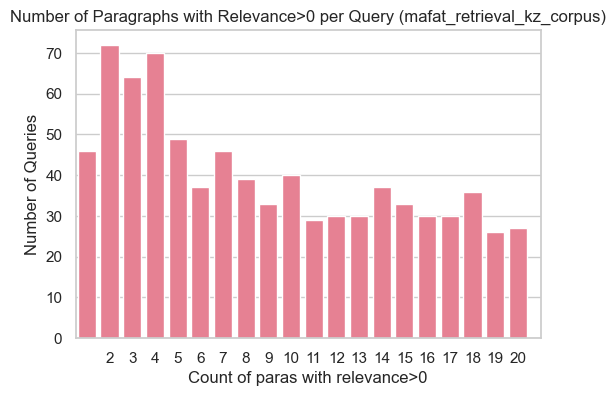

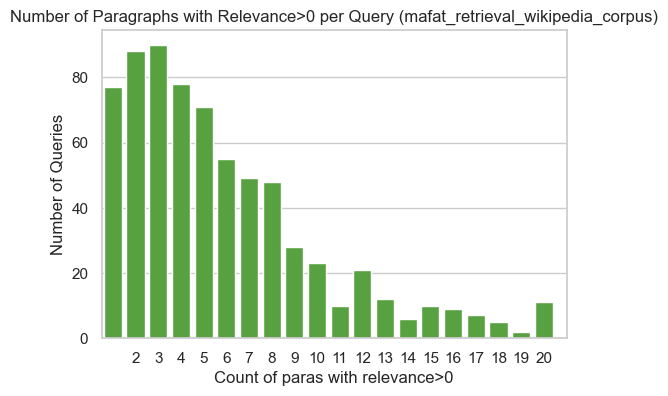

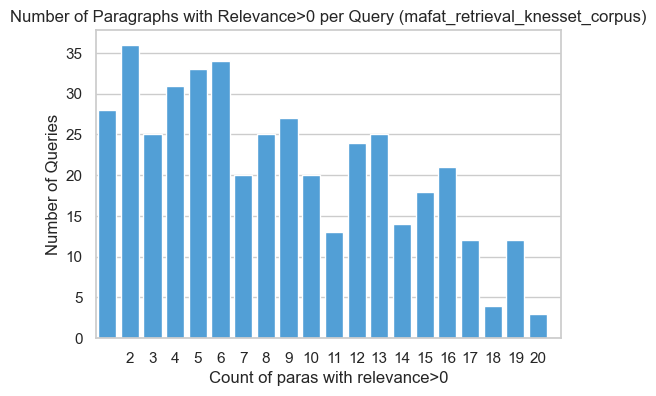

In [15]:
# how many relevant (relevance>0) paras per query?
nonzero_per_q = df_long[df_long.relevance_num>0].groupby('query_uuid').size()
# Split the queries by source
sources = df_long['source'].unique()
# turn the Series into a DataFrame column
tmp = nonzero_per_q.reset_index()
tmp.columns = ['query_uuid','n_relevant']
# Create a plot for each source
for case in sources:
    color = sns.color_palette("husl", len(sources))[list(sources).index(case)]
    case_data = tmp[tmp['query_uuid'].isin(df_long[df_long['source'] == case]['query_uuid'])]
    plt.figure(figsize=(6, 4))
    sns.countplot(x='n_relevant', data=case_data, color=color)
    plt.title(f"Number of Paragraphs with Relevance>0 per Query ({case})")
    plt.xlabel("Count of paras with relevance>0")
    plt.ylabel("Number of Queries")
    plt.xticks(range(case_data['n_relevant'].min(), case_data['n_relevant'].max() + 1))
    plt.show()

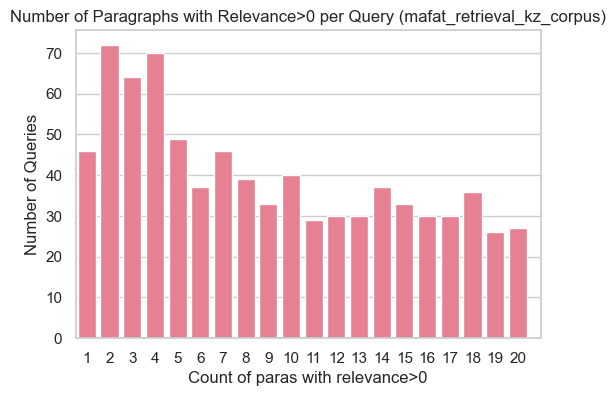

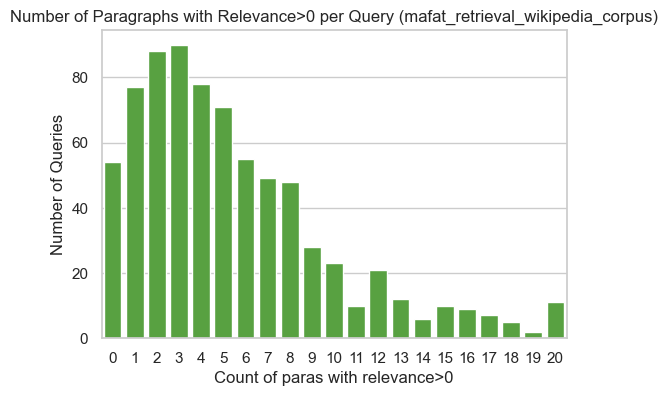

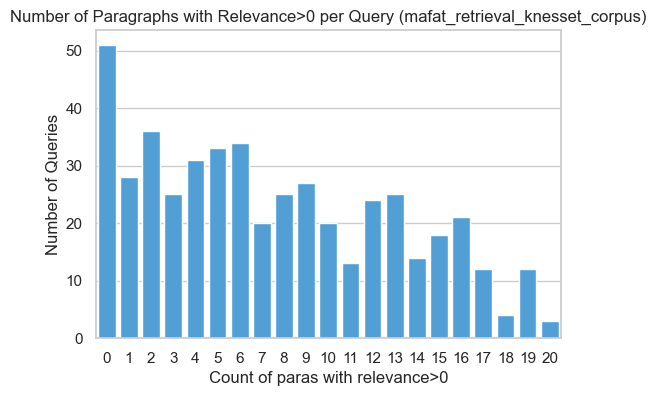

In [16]:
# (추가) relevance가 모두 0인 쿼리도 포함해서 display.
# -> kz엔 없고, wikipedia와 knesset에 합쳐서 105개 있는 것으로 나타남.

# 1) 원본 훼손 없이 필요한 컬럼만 복사해서 임시 DF 만들기
tmp_labels = df_long[['query_uuid', 'source', 'relevance']].copy()

# 2) 문자열일 수 있는 relevance를 숫자로 변환 (임시 컬럼, 원본 불변)
tmp_labels['relevance_num'] = pd.to_numeric(tmp_labels['relevance'], errors='coerce').fillna(0).astype(int)

# 3) (source, query_uuid)별로 relevance>0 개수 집계 → 0도 포함됨
n_rel_per_q = (
    tmp_labels
    .groupby(['source', 'query_uuid'])['relevance_num']
    .apply(lambda s: (s > 0).sum())
    .reset_index(name='n_relevant')
)

# 4) source별 히스토그램 그리기 (x축 0부터 강제 표기)
# 원하는 순서 정의
ordered_sources = [
    'mafat_retrieval_kz_corpus',
    'mafat_retrieval_wikipedia_corpus',
    'mafat_retrieval_knesset_corpus'
]

palette = sns.color_palette("husl", len(ordered_sources))

for i, case in enumerate(ordered_sources):
    case_data = n_rel_per_q[n_rel_per_q['source'] == case]

    plt.figure(figsize=(6, 4))
    sns.countplot(x='n_relevant', data=case_data, color=palette[i])
    plt.title(f"Number of Paragraphs with Relevance>0 per Query ({case})")
    plt.xlabel("Count of paras with relevance>0")
    plt.ylabel("Number of Queries")
    plt.xticks(range(0, case_data['n_relevant'].max() + 1))  # 0부터 강제
    plt.show()

In [17]:
# 1) 라벨을 숫자로 보정
df_long['relevance_num'] = pd.to_numeric(df_long['relevance'], errors='coerce').fillna(0).astype(int)

# 2) (선택) 특정 source만 보고 싶다면 여기서 필터
# case = 'mafat_retrieval_kz_corpus'
# df_case = df_long[df_long['source'] == case].copy()
# 전체를 보려면:
df_case = df_long.copy()

# 3) 쿼리별로 "양수 레이블 존재 여부" 계산 (한 줄로 끝)
has_pos = df_case.groupby('query_uuid')['relevance_num'].max() > 0

n_total = has_pos.shape[0]              # 전체 쿼리 수
n_pos   = has_pos.sum()                 # 양수(>0) 레이블 가진 쿼리 수
n_zero  = (~has_pos).sum()              # 전부 0인 쿼리 수

print("Total queries:", n_total)
print("Queries with relevance>0:", n_pos)
print("Queries with only relevance=0:", n_zero)
print("Sanity check (pos + zero == total):", n_pos + n_zero == n_total)

print("Rows:",      len(df_long))
print("Queries:",   df_long['query_uuid'].nunique())
print("Paragraphs:", len(df_long))
print("Relevance labels:", sorted(df_long['relevance'].unique()))

Total queries: 2034
Queries with relevance>0: 1929
Queries with only relevance=0: 105
Sanity check (pos + zero == total): True
Rows: 40680
Queries: 2034
Paragraphs: 40680
Relevance labels: ['0', '1', '2', '3', '4']


## Distribution of paragraph length

Total passages: 40680
Min length: 3
Max length: 1728
Average length: 176.76

Sample distribution (length: count):
3: 8
4: 6
5: 12
6: 3
7: 2
8: 6
12: 5
13: 1
14: 8
18: 15
19: 5
20: 17
21: 9
22: 15
23: 9
24: 23
25: 7
26: 7
27: 13
28: 8


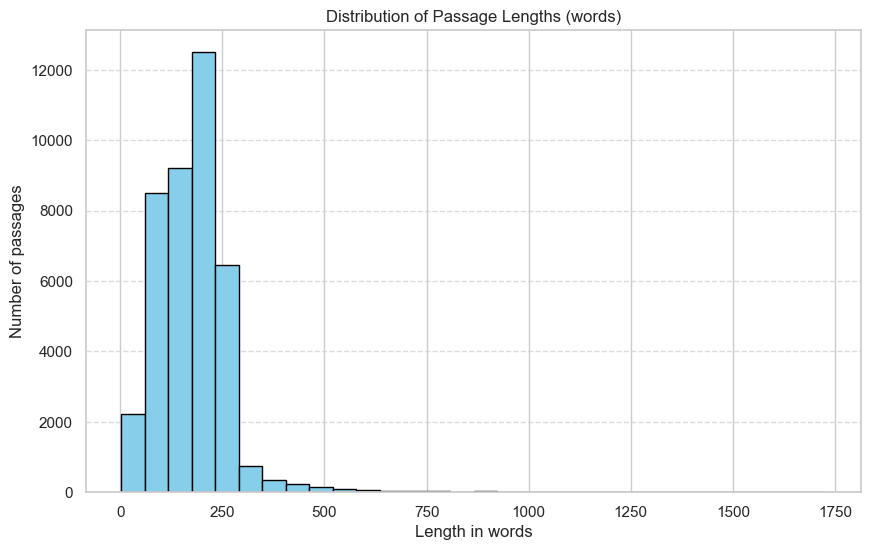

In [18]:
from collections import Counter

# Choose: "chars" for characters, "words" for words
length_type = "words"

lengths = []

# Read the JSONL file
with open(file_path, "r", encoding="utf-8") as f:
    for line in f:
        if line.strip():
            data = json.loads(line)
            paragraphs = data.get("paragraphs", {})
            for para in paragraphs.values():
                passage = para.get("passage", "")
                if length_type == "chars":
                    lengths.append(len(passage))
                elif length_type == "words":
                    lengths.append(len(passage.split()))

# Stats
print(f"Total passages: {len(lengths)}")
print(f"Min length: {min(lengths)}")
print(f"Max length: {max(lengths)}")
print(f"Average length: {sum(lengths)/len(lengths):.2f}")

# Distribution table
distribution = Counter(lengths)
print("\nSample distribution (length: count):")
for length, count in sorted(distribution.items())[:20]:
    print(f"{length}: {count}")

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=30, color='skyblue', edgecolor='black')
plt.title(f"Distribution of Passage Lengths ({length_type})")
plt.xlabel(f"Length in {length_type}")
plt.ylabel("Number of passages")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Advanced Feature Analysis

### Cosine Similarity Analysis

Calculate cosine similarity between queries and paragraphs using TF-IDF vectorization to understand the relationship between semantic similarity and relevance scores.


In [20]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def calculate_cosine_similarity_me5_optimized(df, sample_size=500):
    """Calculate cosine similarity using ME5 with optimizations"""
    similarities = []
    
    # Sample the data for faster processing
    print(f"Sampling {sample_size} queries from {df['query_uuid'].nunique()} total queries")
    sampled_queries = df['query_uuid'].unique()[:sample_size]
    df_sample = df[df['query_uuid'].isin(sampled_queries)]
    
    # Use smaller, faster model
    print("Loading multilingual-e5-base (faster than large)...")
    model = SentenceTransformer('intfloat/multilingual-e5-base')
    print("Model loaded successfully!")
    
    # Process in batches for efficiency
    batch_size = 32
    
    for i, (query_uuid, group) in enumerate(df_sample.groupby('query_uuid')):
        if i % 50 == 0:  # More frequent progress updates
            print(f"Processing query {i+1}/{len(sampled_queries)}")
        
        query_text = group['query'].iloc[0]
        paragraph_texts = group['paragraph_text'].tolist()
        
        # Truncate very long texts to speed up processing
        query_text = query_text[:512] if len(query_text) > 512 else query_text
        paragraph_texts = [text[:512] if len(text) > 512 else text for text in paragraph_texts]
        
        try:
            # Add prefixes for better performance
            query_with_prefix = f"query: {query_text}"
            paragraphs_with_prefix = [f"passage: {text}" for text in paragraph_texts]
            
            # Encode query
            query_embedding = model.encode([query_with_prefix], batch_size=1)
            
            # Encode paragraphs in batch
            paragraph_embeddings = model.encode(paragraphs_with_prefix, batch_size=batch_size)
            
            # Calculate cosine similarity
            cosine_sims = cosine_similarity(query_embedding, paragraph_embeddings).flatten()
            similarities.extend(cosine_sims)
            
        except Exception as e:
            print(f"Error processing query {query_uuid}: {e}")
            similarities.extend([0.0] * len(paragraph_texts))
    
    return similarities, df_sample

print("Calculating cosine similarities using optimized ME5...")
similarities, df_sample = calculate_cosine_similarity_me5_optimized(df_long, sample_size=500)
df_sample['cosine_similarity_me5'] = similarities
print("ME5 cosine similarity calculation completed!")

# Use the sampled data for analysis
df_long = df_sample.copy()

Calculating cosine similarities using optimized ME5...
Sampling 500 queries from 2034 total queries
Loading multilingual-e5-base (faster than large)...


ValueError: Could not find XLMRobertaModel neither in <module 'transformers.models.xlm_roberta' from 'C:\\Users\\성은\\AppData\\Roaming\\Python\\Python310\\site-packages\\transformers\\models\\xlm_roberta\\__init__.py'> nor in <module 'transformers' from 'C:\\Users\\성은\\AppData\\Roaming\\Python\\Python310\\site-packages\\transformers\\__init__.py'>!

### Correlation Analysis with Cosine Similarity

Examine the relationship between cosine similarity and relevance scores, along with other text-based features.


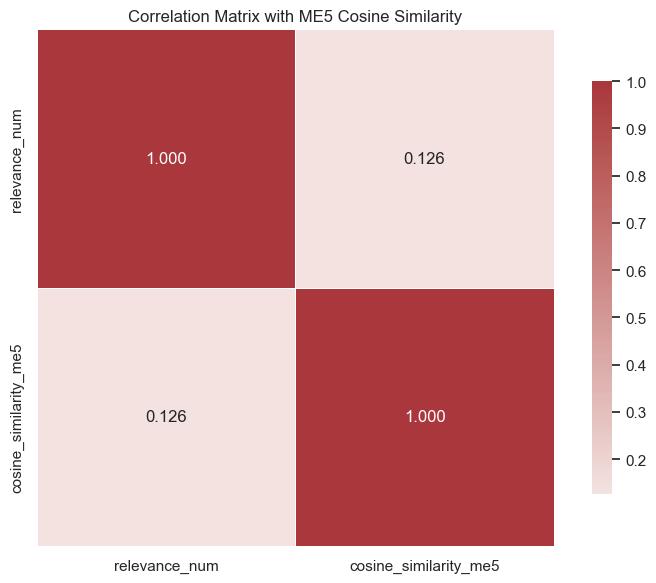

Features sorted by |correlation| with relevance:
cosine_similarity_me5: 0.1262


In [ ]:
# Update the correlation analysis to include ME5 cosine similarity
num_cols = ['relevance_num', 'cosine_similarity_me5']

# Compute the correlation matrix
corr = df_long[num_cols].corr()

# Plot a larger heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".3f", cmap="vlag", center=0, linewidths=.5,
            square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Matrix with ME5 Cosine Similarity")
plt.tight_layout()
plt.show()

# Print features sorted by absolute correlation with relevance
print("Features sorted by |correlation| with relevance:")
relevance_corr = corr['relevance_num'].drop('relevance_num').abs().sort_values(ascending=False)
for feature, correlation in relevance_corr.items():
    print(f"{feature}: {correlation:.4f}")

### Cosine Similarity Distribution by Relevance

Visualize how cosine similarity values are distributed across different relevance scores.


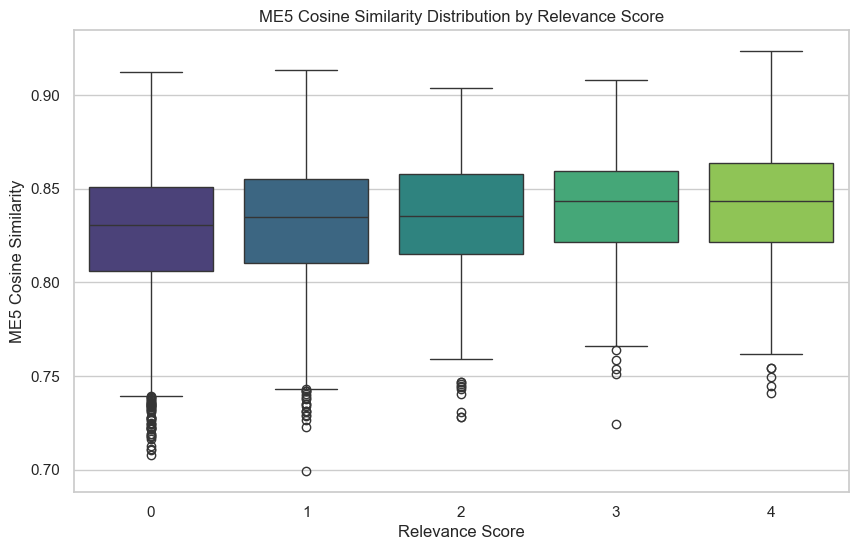

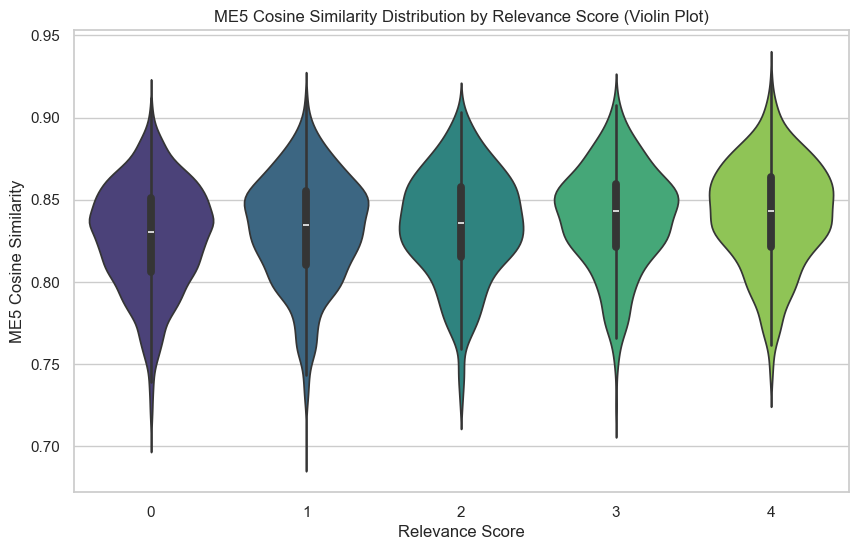

ME5 Cosine Similarity Statistics by Relevance Score:
                count      mean       std       min       25%       50%  \
relevance_num                                                             
0              6262.0  0.827389  0.032384  0.707676  0.806267  0.830578   
1              1976.0  0.831426  0.032900  0.699152  0.810231  0.834601   
2               689.0  0.833922  0.032261  0.727963  0.815356  0.835531   
3               378.0  0.838666  0.030812  0.724153  0.821369  0.843159   
4               695.0  0.841033  0.031523  0.741010  0.821475  0.843284   

                    75%       max  
relevance_num                      
0              0.851001  0.911995  
1              0.855046  0.913207  
2              0.857562  0.903683  
3              0.859628  0.907857  
4              0.863743  0.923336  


In [ ]:
# Create box plot showing cosine similarity distribution by relevance score
plt.figure(figsize=(10, 6))
sns.boxplot(x='relevance_num', y='cosine_similarity_me5', data=df_long, palette="viridis")
plt.title("ME5 Cosine Similarity Distribution by Relevance Score")
plt.xlabel("Relevance Score")
plt.ylabel("ME5 Cosine Similarity")
plt.show()

# Create violin plot for more detailed distribution
plt.figure(figsize=(10, 6))
sns.violinplot(x='relevance_num', y='cosine_similarity_me5', data=df_long, palette="viridis")
plt.title("ME5 Cosine Similarity Distribution by Relevance Score (Violin Plot)")
plt.xlabel("Relevance Score")
plt.ylabel("ME5 Cosine Similarity")
plt.show()

# Print summary statistics
print("ME5 Cosine Similarity Statistics by Relevance Score:")
print(df_long.groupby('relevance_num')['cosine_similarity_me5'].describe())

### Scatter Plot Analysis

Examine the direct relationship between cosine similarity and relevance scores.


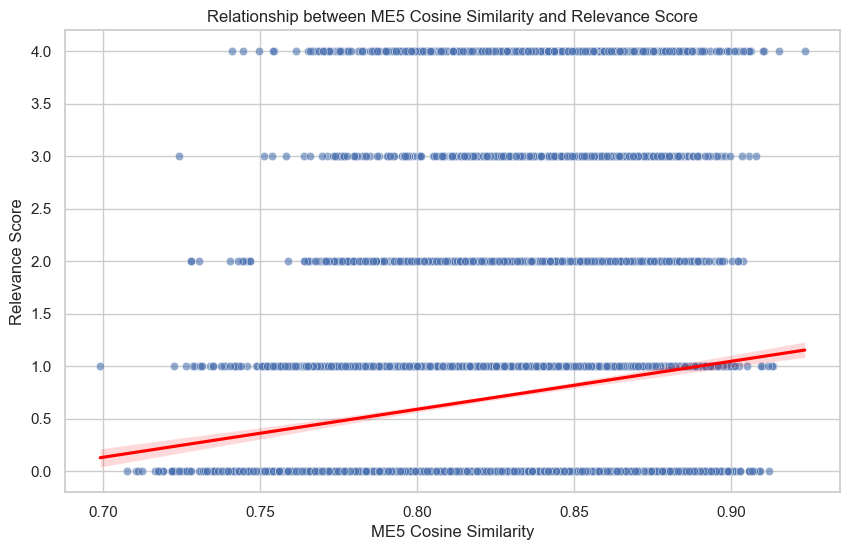

Pearson correlation between ME5 cosine similarity and relevance: 0.1262
P-value: 9.1362e-37
Spearman correlation between ME5 cosine similarity and relevance: 0.1169
P-value: 9.0950e-32


In [ ]:
# Scatter plot with trend line
plt.figure(figsize=(10, 6))
sns.scatterplot(x='cosine_similarity_me5', y='relevance_num', data=df_long, alpha=0.6)
sns.regplot(x='cosine_similarity_me5', y='relevance_num', data=df_long, scatter=False, color='red')
plt.title("Relationship between ME5 Cosine Similarity and Relevance Score")
plt.xlabel("ME5 Cosine Similarity")
plt.ylabel("Relevance Score")
plt.show()

# Calculate and display Pearson correlation coefficient
from scipy.stats import pearsonr
correlation, p_value = pearsonr(df_long['cosine_similarity_me5'], df_long['relevance_num'])
print(f"Pearson correlation between ME5 cosine similarity and relevance: {correlation:.4f}")
print(f"P-value: {p_value:.4e}")

# Calculate Spearman correlation (rank-based)
from scipy.stats import spearmanr
spearman_corr, spearman_p = spearmanr(df_long['cosine_similarity_me5'], df_long['relevance_num'])
print(f"Spearman correlation between ME5 cosine similarity and relevance: {spearman_corr:.4f}")
print(f"P-value: {spearman_p:.4e}")

---
### 내가 만든 모델 테스트

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if not hasattr(np, "bool"):
    np.bool = np.bool_
import seaborn as sns

import importlib, model1; importlib.reload(model1)
from model1 import AlephBertDPRRetriever


from sklearn.metrics.pairwise import cosine_similarity

def calculate_cosine_similarity_dpr_optimized(df, retriever, sample_size=500, batch_size_passages=64, seed=42):
    """
    AlephBERT DPR로 쿼리-패시지 코사인 유사도 계산.
    - df: long format DataFrame with columns ['query_uuid','query','paragraph_text',...]
    - retriever: AlephBertDPRRetriever 인스턴스 (이미 로드되어 있다고 가정)
    - sample_size: 추출할 query_uuid 개수
    - batch_size_passages: passage 임베딩 배치 크기
    - return: df_sample (원본 일부 샘플 + 'cosine_similarity_dpr' 열 추가)
    """
    # 유효한 쿼리만 추출
    uuids = df['query_uuid'].dropna().unique().tolist()
    n_total = len(uuids)
    if n_total == 0:
        raise ValueError("No query_uuid found in dataframe.")

    # 샘플링 (무작위)
    rng = np.random.default_rng(seed)
    if sample_size is None or sample_size <= 0:
        chosen = uuids
    else:
        k = min(sample_size, n_total)
        chosen = rng.choice(uuids, size=k, replace=False).tolist()

    # 샘플 데이터프레임 구성 (원본 순서 보존)
    df_sample = df[df['query_uuid'].isin(chosen)].copy()

    # 안전: 열 존재 체크
    for col in ['query_uuid', 'query', 'paragraph_text']:
        if col not in df_sample.columns:
            raise KeyError(f"Required column '{col}' not found in dataframe.")

    # 모델 eval 모드 권장 (외부 컨트롤 유지)
    if hasattr(retriever, "query_encoder") and hasattr(retriever.query_encoder, "eval"):
        retriever.query_encoder.eval()
    if hasattr(retriever, "passage_encoder") and hasattr(retriever.passage_encoder, "eval"):
        retriever.passage_encoder.eval()

    # 결과 열 초기화
    df_sample['cosine_similarity_dpr'] = np.nan

    # 그룹 단위로 유사도 계산 후, 해당 인덱스에 바로 써넣기(순서 꼬임 방지)
    grouped = df_sample.groupby('query_uuid', sort=False)

    print(f"Sampling {len(chosen)} queries from {n_total} total queries")
    for i, (q_uuid, group) in enumerate(grouped, start=1):
        if i % 50 == 0:
            print(f"Processing query {i}/{len(chosen)}")

        query_text = str(group['query'].iloc[0]) if len(group) else ""
        para_texts = [str(t) if not isinstance(t, str) else t for t in group['paragraph_text'].tolist()]

        try:
            # 쿼리 / 패시지 임베딩
            q_emb = retriever.embed_texts([query_text], is_query=True, batch_size=1)  # [1, H]
            p_emb = retriever.embed_texts(para_texts, is_query=False, batch_size=batch_size_passages)  # [N, H]

            sims = cosine_similarity(q_emb, p_emb).ravel()  # [N]
            # 해당 group의 인덱스 위치에 바로 기록
            df_sample.loc[group.index, 'cosine_similarity_dpr'] = sims.astype(np.float32)

        except Exception as e:
            print(f"[WARN] Error processing query {q_uuid}: {e}")
            df_sample.loc[group.index, 'cosine_similarity_dpr'] = 0.0

    # float 변환/결측 방지
    df_sample['cosine_similarity_dpr'] = df_sample['cosine_similarity_dpr'].astype(float).fillna(0.0)

    return df_sample


# =========================
# 실행 예시 (Retrieval quick test)
# =========================

# 1) retriever 준비 (이미 로드했다면 재사용)
retriever = AlephBertDPRRetriever(
    query_model_name=None,       # 자동 탐색 로직 사용
    passage_model_name=None,     # 자동 탐색 로직 사용
    pooling="cls",               # or "mean" 비교 가능
    proj_dim=None,               # 필요시 384 등
    max_length=256,
    use_fp16_if_cuda=True
)

# 2) 유사도 계산
print("Calculating cosine similarities using AlephBERT DPR...")
df_sample = calculate_cosine_similarity_dpr_optimized(
    df=df_long,                 # 너의 long 포맷 DF
    retriever=retriever,
    sample_size=500,            # 필요에 맞게 조절
    batch_size_passages=64,     # GPU 메모리에 따라 조절
    seed=42
)
print("AlephBERT DPR cosine similarity calculation completed!")

# 3) 박스/바이올린 플롯 (라벨 열 이름 유지)
plt.figure(figsize=(10, 6))
sns.boxplot(x='relevance_num', y='cosine_similarity_dpr', data=df_sample, palette="viridis")
plt.title("AlephBERT-DPR Cosine Similarity by Relevance Score (Box Plot)")
plt.xlabel("Relevance Score")
plt.ylabel("Cosine Similarity (DPR)")
plt.show()

plt.figure(figsize=(10, 6))
sns.violinplot(x='relevance_num', y='cosine_similarity_dpr', data=df_sample, palette="viridis")
plt.title("AlephBERT-DPR Cosine Similarity by Relevance Score (Violin Plot)")
plt.xlabel("Relevance Score")
plt.ylabel("Cosine Similarity (DPR)")
plt.show()

# 4) 통계 요약
print("AlephBERT-DPR Cosine Similarity Statistics by Relevance Score:")
print(df_sample.groupby('relevance_num')['cosine_similarity_dpr'].describe())

[DPR] Loading query encoder:   onlplab/alephbert-base
[DPR] Loading passage encoder: onlplab/alephbert-base
Device: cuda


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


ValueError: Due to a serious vulnerability issue in `torch.load`, even with `weights_only=True`, we now require users to upgrade torch to at least v2.6 in order to use the function. This version restriction does not apply when loading files with safetensors.
See the vulnerability report here https://nvd.nist.gov/vuln/detail/CVE-2025-32434

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


In [19]:
import sys
# 안정 조합으로 다운핀
!"{sys.executable}" -m pip install --upgrade --force-reinstall "sentence-transformers==2.7.0" "accelerate==0.34.2"

Defaulting to user installation because normal site-packages is not writeable
  Using cached transformers-4.57.0-py3-none-any.whl.metadata (41 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached torch-2.8.0-cp310-cp310-win_amd64.whl.metadata (30 kB)
  Using cached numpy-2.2.6-cp310-cp310-win_amd64.whl.metadata (60 kB)
  Using cached scikit_learn-1.7.2-cp310-cp310-win_amd64.whl.metadata (11 kB)
  Using cached scipy-1.15.3-cp310-cp310-win_amd64.whl.metadata (60 kB)
  Using cached huggingface_hub-0.35.3-py3-none-any.whl.metadata (14 kB)
  Using cached pillow-11.3.0-cp310-cp310-win_amd64.whl.metadata (9.2 kB)
  Using cached packaging-25.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached psutil-7.1.0-cp37-abi3-win_amd64.whl.metadata (23 kB)
  Using cached pyyaml-6.0.3-cp310-cp310-win_amd64.whl.metadata (2.4 kB)
  Using cached safetensors-0.6.2-cp38-abi3-win_amd64.whl.metadata (4.1 kB)
  Using cached regex-2025.9.18-cp310-cp310-win_amd64.whl.metadata (41 kB)
  Us

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account al

In [1]:
import torch, sentence_transformers, accelerate
print('torch:', torch.__version__)
print('sbert:', sentence_transformers.__version__)
print('accelerate:', accelerate.__version__)
from sentence_transformers import SentenceTransformer  # ← 이제 여기서 에러 없어야 정상

C:\Users\성은\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch: 2.8.0+cpu
sbert: 2.7.0
accelerate: 0.34.2


In [1]:
import sys, torch, transformers, sentence_transformers, accelerate
print("python exe:", sys.executable)
print("torch:", torch.__version__)
print("transformers:", transformers.__version__, "| path:", transformers.__file__)
print("sbert:", sentence_transformers.__version__)
print("accelerate:", accelerate.__version__)


C:\Users\성은\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.
0it [00:00, ?it/s]


ImportError: DLL load failed while importing lib: 지정된 프로시저를 찾을 수 없습니다.

In [2]:
import importlib, traceback
mods = ["tokenizers","sentencepiece","transformers","sentence_transformers","accelerate"]
for m in mods:
    try:
        importlib.import_module(m)
        print(f"{m}: OK")
    except Exception as e:
        print(f"{m}: FAIL")
        traceback.print_exc(limit=2)


tokenizers: OK
sentencepiece: OK
transformers: OK
sentence_transformers: FAIL
accelerate: OK


Traceback (most recent call last):
  File "C:\Users\성은\AppData\Local\Temp\ipykernel_12556\3027178445.py", line 5, in <module>
    importlib.import_module(m)
  File "c:\ProgramData\anaconda3\envs\hebrew\lib\importlib\__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
ImportError: DLL load failed while importing lib: 지정된 프로시저를 찾을 수 없습니다.


In [4]:
import os
os.environ["PYTHONNOUSERSITE"] = "1"

import sys
!"{sys.executable}" -m pip uninstall -y sentence-transformers


Found existing installation: sentence-transformers 2.7.0
Uninstalling sentence-transformers-2.7.0:


ERROR: Exception:
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\envs\hebrew\lib\shutil.py", line 816, in move
    os.rename(src, real_dst)
PermissionError: [WinError 5] 액세스가 거부되었습니다: 'c:\\programdata\\anaconda3\\envs\\hebrew\\lib\\site-packages\\sentence_transformers-2.7.0.dist-info\\' -> 'C:\\Users\\성은\\AppData\\Local\\Temp\\pip-uninstall-k1_fbzbo'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\envs\hebrew\lib\site-packages\pip\_internal\cli\base_command.py", line 107, in _run_wrapper
    status = _inner_run()
  File "c:\ProgramData\anaconda3\envs\hebrew\lib\site-packages\pip\_internal\cli\base_command.py", line 98, in _inner_run
    return self.run(options, args)
  File "c:\ProgramData\anaconda3\envs\hebrew\lib\site-packages\pip\_internal\commands\uninstall.py", line 105, in run
    uninstall_pathset = req.uninstall(
  File "c:\ProgramData\anaconda3\envs\hebrew\lib\site-pa

In [1]:
from sentence_transformers import SentenceTransformer
print("✅ import ok")


C:\Users\성은\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ImportError: DLL load failed while importing lib: 지정된 프로시저를 찾을 수 없습니다.